In [4]:
from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.functions import lower, col, count, concat_ws
from pyspark.sql.types import Row
from pyspark import RDD
from typing import List, Tuple, Callable, Dict, Optional, Any, NamedTuple
import numpy as np
import scipy.stats as stats
from tqdm import tqdm

spark = (SparkSession.builder.appName("pacdb")
         .config("spark.executor.memory", "512M")
         .config("spark.sql.warehouse.dir", ".spark")
         .enableHiveSupport()
         .getOrCreate())

spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

# set font to Times New Roman
LATEX = False
if LATEX:
    mpl.rcParams['text.usetex'] = True
    mpl.rcParams["font.family"] = "serif"
    mpl.rcParams["font.serif"] = "Times"
else:
    mpl.rcParams['text.usetex'] = False
    mpl.rcParams["font.family"] = "Times New Roman"

plt.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['savefig.dpi'] = 300

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

mpl.rcParams['axes.titleweight'] = 'bold'

24/03/12 23:14:36 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


### Data Exploration

Source - https://archive.ics.uci.edu/dataset/320/student+performance 

In [9]:
math_df = spark.read.csv("./data/student_performance/student-mat.csv", header=True, inferSchema=True, sep=";")
portuguese_df = spark.read.csv("./data/student_performance/student-por.csv", header=True, inferSchema=True, sep=";")

In [10]:
math_df.printSchema()
math_df.show(5)

root
 |-- school: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- address: string (nullable = true)
 |-- famsize: string (nullable = true)
 |-- Pstatus: string (nullable = true)
 |-- Medu: integer (nullable = true)
 |-- Fedu: integer (nullable = true)
 |-- Mjob: string (nullable = true)
 |-- Fjob: string (nullable = true)
 |-- reason: string (nullable = true)
 |-- guardian: string (nullable = true)
 |-- traveltime: integer (nullable = true)
 |-- studytime: integer (nullable = true)
 |-- failures: integer (nullable = true)
 |-- schoolsup: string (nullable = true)
 |-- famsup: string (nullable = true)
 |-- paid: string (nullable = true)
 |-- activities: string (nullable = true)
 |-- nursery: string (nullable = true)
 |-- higher: string (nullable = true)
 |-- internet: string (nullable = true)
 |-- romantic: string (nullable = true)
 |-- famrel: integer (nullable = true)
 |-- freetime: integer (nullable = true)
 |-- goout: integer (null

24/03/12 23:22:35 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+------+---+---+-------+-------+-------+----+----+-------+--------+------+--------+----------+---------+--------+---------+------+----+----------+-------+------+--------+--------+------+--------+-----+----+----+------+--------+---+---+---+
|school|sex|age|address|famsize|Pstatus|Medu|Fedu|   Mjob|    Fjob|reason|guardian|traveltime|studytime|failures|schoolsup|famsup|paid|activities|nursery|higher|internet|romantic|famrel|freetime|goout|Dalc|Walc|health|absences| G1| G2| G3|
+------+---+---+-------+-------+-------+----+----+-------+--------+------+--------+----------+---------+--------+---------+------+----+----------+-------+------+--------+--------+------+--------+-----+----+----+------+--------+---+---+---+
|    GP|  F| 18|      U|    GT3|      A|   4|   4|at_home| teacher|course|  mother|         2|        2|       0|      yes|    no|  no|        no|    yes|   yes|      no|      no|     4|       3|    4|   1|   1|     3|       6|  5|  6|  6|
|    GP|  F| 17|      U|    GT3|      T|

In [14]:
portuguese_df.printSchema()
portuguese_df.show(10)

root
 |-- school: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- address: string (nullable = true)
 |-- famsize: string (nullable = true)
 |-- Pstatus: string (nullable = true)
 |-- Medu: integer (nullable = true)
 |-- Fedu: integer (nullable = true)
 |-- Mjob: string (nullable = true)
 |-- Fjob: string (nullable = true)
 |-- reason: string (nullable = true)
 |-- guardian: string (nullable = true)
 |-- traveltime: integer (nullable = true)
 |-- studytime: integer (nullable = true)
 |-- failures: integer (nullable = true)
 |-- schoolsup: string (nullable = true)
 |-- famsup: string (nullable = true)
 |-- paid: string (nullable = true)
 |-- activities: string (nullable = true)
 |-- nursery: string (nullable = true)
 |-- higher: string (nullable = true)
 |-- internet: string (nullable = true)
 |-- romantic: string (nullable = true)
 |-- famrel: integer (nullable = true)
 |-- freetime: integer (nullable = true)
 |-- goout: integer (null

## Defining the Benchmark

Reference - 
[1] Garrido, G. M., Near, J., Muhammad, A., He, W., Matzutt, R., & Matthes, F. (2021). Do I get the privacy I need? Benchmarking utility in differential privacy libraries. arXiv preprint arXiv:2109.10789.

[1] defines two attributes as sensitive - _absence_days_ and _final_exam_grade_. They also state that - 

"To set the range bounds for the sensitivity calculation, we selected values based on the domain knowledge of the real-world datasets’ attributes, e.g., for the age attribute, we selected a lower bound and an upper bound of 0 and a 100 years, respectively."

We follow the same setup.

Test Queries for PAC-DB and PipelineDP
1. Count, Sum, Mean, Var
2.  

## Count

In [16]:
# Non-private query

defaulters = math_df.filter(math_df["absences"] >= 5) # More than 5 absent days
defaulters.count()

151

In [26]:
# Private Query
# Step 1 - Create a custom PACDataFrame object

from pacdb import PACDataFrame, Sampler, DataFrameSampler, SamplerOptions, QueryRewriter

user_defined_sampling_rate = 0.5

# created a new PACDataFrame object
pac_defaulters_df = (PACDataFrame(math_df)
                .withSamplerOptions(
                    SamplerOptions(
                        withReplacement=False,                  # should be false given get_samples_safe() logic 
                                                                #    - perhaps no custom input for this?
                        fraction=user_defined_sampling_rate,    # fixed sampling rate of 0.5
                        columns_to_sample_by=None
                    )
                ))

pac_defaulters_df.sample().toPandas().head()
# print(len(pac_defaulters_df)) ---maybe add a length function?
# del pac_lung_df


/Users/chaitanyasuma/Library/Python/3.9/lib/python/site-packages/pyspark/sql/pandas/conversion.py:111: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 4.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
1,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
2,GP,M,16,U,LE3,T,4,3,services,other,...,5,4,2,1,2,5,10,15,15,15
3,GP,M,16,U,LE3,T,2,2,other,other,...,4,4,4,1,1,3,0,12,12,11
4,GP,F,17,U,GT3,A,4,4,other,teacher,...,4,1,4,1,1,1,6,6,5,6


In [ ]:
# Step 2 - Sample the custom PACDataFrame

from pacdb import QueryRewriter, Aggregator
trials = 200

# filter = pac_defaulters_df.add_filter("math_df[\"absences\"] >= 5")
# aggr = pac_defaulters_df.map_to_function("count")

# samples = pac_defaulters_df.get_samples(pac_defaulters_df, user_defined_sampling_rate, filter, aggr, trials)



In [27]:
trials = 200 * 2
sampling_rate = 0.5

samples = []

for i in tqdm(range(trials)):
    s = (pac_defaulters_df.sample()
         .filter(math_df["absences"] >= 5)  # run query on sample
         .count())
    samples.append(s)  # store result of query

samples = [s * (1/sampling_rate) for s in samples]  # so that counts are not halved

100%|██████████| 400/400 [00:28<00:00, 13.98it/s]


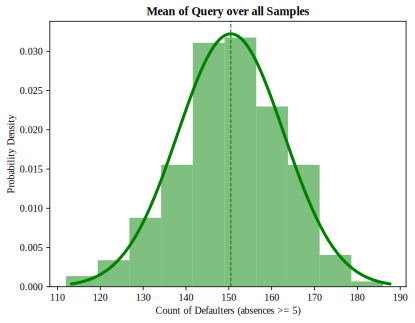

In [31]:
# Plotting the samples

plt.hist(samples, bins=10, density=True, alpha=0.5, color='g')

mu = np.mean(samples)
sigma = np.std(samples)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma), color='g', linewidth=3)

# highlight mean
plt.axvline(mu, color='g', linestyle='dashed', linewidth=1)
# label
#plt.text(mu+17, 0.0117, f'$\mu={mu:.2f}$', ha='center', va='top', fontsize=8)

# label the axes
plt.title('Mean of Query over all Samples')
plt.xlabel('Count of Defaulters (absences >= 5)')
plt.ylabel('Probability Density')
plt.savefig("figs/student_performance/samples1.png")

In [32]:
# Step 3: Calculate Noise

sampled_counts = samples
pairwise_differences = []

for i in range(len(sampled_counts)):
    for j in range(i + 1, len(sampled_counts)):
        difference = sampled_counts[i] - sampled_counts[j]
        pairwise_differences.append(difference)

In [34]:
import paclib
import paclib.mechanism

c = 0.001
budget = 1/32

avg_dist = np.mean(pairwise_differences)

# At different levels of MI, compute noise to add
noise_params = []
for budget in [1/64, 1/32, 1/16, 1/8, 1/4, 1/2, 1., 2., 4.]:
    print(f"avg_dist: {budget}, c: {c}, max_mi: {budget:8} => {paclib.mechanism.noise_to_add_parameters(avg_dist, c, budget)}")
    noise_params.append([budget, paclib.mechanism.noise_to_add_parameters(avg_dist, c, budget).mean, paclib.mechanism.noise_to_add_parameters(avg_dist, c, budget).variance])

avg_dist: 0.015625, c: 0.001, max_mi: 0.015625 => GaussianDistribution(mean=0, variance=-56.21269172932331)
avg_dist: 0.03125, c: 0.001, max_mi:  0.03125 => GaussianDistribution(mean=0, variance=-28.106345864661655)
avg_dist: 0.0625, c: 0.001, max_mi:   0.0625 => GaussianDistribution(mean=0, variance=-14.053172932330828)
avg_dist: 0.125, c: 0.001, max_mi:    0.125 => GaussianDistribution(mean=0, variance=-7.026586466165414)
avg_dist: 0.25, c: 0.001, max_mi:     0.25 => GaussianDistribution(mean=0, variance=-3.513293233082707)
avg_dist: 0.5, c: 0.001, max_mi:      0.5 => GaussianDistribution(mean=0, variance=-1.7566466165413535)
avg_dist: 1.0, c: 0.001, max_mi:      1.0 => GaussianDistribution(mean=0, variance=-0.8783233082706767)
avg_dist: 2.0, c: 0.001, max_mi:      2.0 => GaussianDistribution(mean=0, variance=-0.43916165413533836)
avg_dist: 4.0, c: 0.001, max_mi:      4.0 => GaussianDistribution(mean=0, variance=-0.21958082706766918)


## Sum

## Mean

PAC-count / PAC-sum vs PAC-mean

## Var

σ^2=n∑i=1 ​(xi​−x)^2 / n 

(Chorus does not implement variance---find out why?)​